# Time Series Analysis: I

*S. R. Taylor (2024)*

This lecture and notebook are based on the "TimeSeries", and "TimeSeries2" lectures of of G. Richards' "Astrostatistics" class at Drexel University (PHYS 440/540, https://github.com/gtrichards/PHYS_440_540), which in turn are based on materials from Andy Connolly, and Ivezic et al. Chapter 10, and Andy Connolly's [blog](http://connolly.github.io/introAstroML/blog/regression.html). I have also benefited from updates and refinements made by Davide Gerosa's class at the University of Milan, Bicocca: https://github.com/dgerosa/astrostatistics_bicocca_2022.

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 10.

---

## Contents
* [Goals Of Time Series Analysis](#one)
* [Parameter Estimation, Model Selection, Classification](#two)
* [Fourier Analysis](#three)
* [Temporally Localized Signals](#four)
* [Periodic Signals](#five)
* [Lomb-Scargle Periodogram](#six)
    
---

***Participation points will be given for this class for successfully producing code output.***

---

Before we get started today, install the following package from Jake VanderPlas for astronomical time-series analysis in Python. It's a little bit old now, but still effective.

In [16]:
!pip install gatspy

From [http://www.astroml.org/gatspy/](http://www.astroml.org/gatspy/):

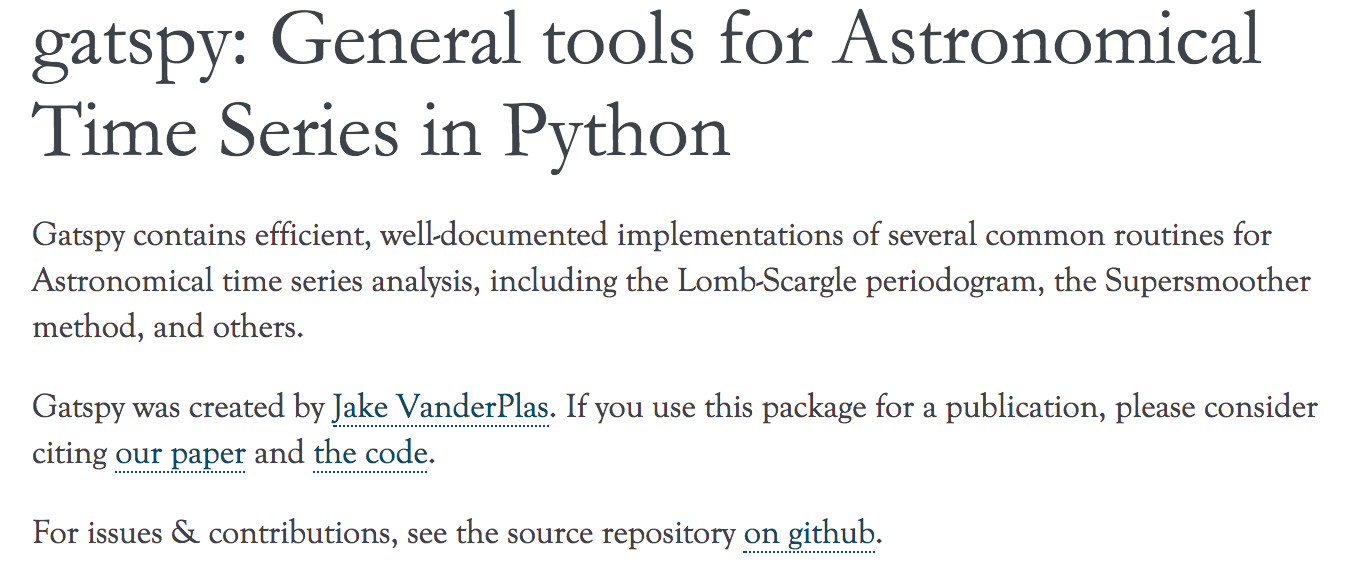

---

**Time series analysis** is, in many ways, very similar to regression analysis, except that we replace $x$ with $t$. However, we have generally assumed that the $y$ values are independent, whereas for time series $y_{i+1}$ is likely to depend directly on $y_i$. That is, time-series data is sequential and consequential, where data are linked over many observations. Furthermore, we can make no assumptions about the regularity of the time sampling, or that we are capturing enough data to fully characterize a long-timescale process.

There is a broad range of variability signatures that we want to be aware of; from transient events to periodic variables to stochastic sources. The following only shows the variability we get from electromagnetic sources, but there is an entire dark Universe of gravitational-wave variability out there too.

[Eyer et al. (2018)](https://gea.esac.esa.int/archive/documentation/GDR2/Data_analysis/chap_cu7var/) 

![](https://www.researchgate.net/profile/Richard-Anderson-27/publication/329541119/figure/fig1/AS:713589518245891@1547144407537/Updated-version-of-the-variability-tree-presented-in-Eyer-Mowlavi-2008-separated.png)

Here are examples of three different types of variable sources.  **First, a flaring star**.  **Second, a periodically variable star (which has a fixed period)**.  **Third, an eclipsing binary star (which has a two-step cycle)**. **Fourth, a gravitational wave signal (which has a period that decreases with time)**.

<img src="https://astrostatistics.psu.edu/datasets/COUP551.jpg" style="float: left; width: 30%; margin-right: 1%;"> <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRJGQ4voqwEQbYbBvS-1OvBfT5pl3GZjYCRciw13YDX8Q&s" style="float: left; width: 30%; margin-right: 1%;"> <img src="https://imagine.gsfc.nasa.gov/Images/educators/lessons/time/binary_lightcurve.gif" style="float: left; width: 30%; margin-right: 1%; margin-bottom: 0.5em;">

![](https://www.physics.fau.edu/~wolf/PublicScience/Grav_GWs_BHs/2PN_150Hz_635Hz_wave_m1_1_75_m2_2_25.jpg)

## Goals Of Time Series Analysis <a class="anchor" id="one"></a>

When dealing with time series data, the first question we ask is

> *Is the system variable over some timescale?*

If not, there is no point doing time series analysis!. Note that variable does **not** mean periodic. Stochastic processes are variable over some timescale, but are distinctly aperiodic through the inherent randomness. In the context of frequentist statistics, the above question is related to whether our data would have been obtained by chance if the no-variability null hypothesis were correct.

If we find that our source *is* variable, then our ***time-series analysis has two main goals***:

1. **Characterize the temporal correlation** between different values of $y$ (i.e., characterize the "light curve"), e.g. by learning the parameters for a model.

2. **Predict** future values of $y$.


If the uncertainties are known and Gaussian, we can simply compute $\chi^2$ and the corresponding $p$ values for variation in a signal.

For a sinusoidal variable signal $A \sin(\omega t)$, with homoescedastic measurement uncertainties, the data model would be

$$ y(t) = A \sin(\omega t) + \epsilon $$
    
where $\epsilon \sim N(0,\sigma)$. The overall data variance is then $V = \sigma^2 + A^2/2$.
    
- ***If $A=0$ (no variability, with $\overline{y}=0$)***

    - $\chi^2_{\rm dof}=N^{-1} \sum_j (y_j/\sigma)^2 \sim V/\sigma^2$.
    - $\chi^2_{\rm dof}$ has  expectation value of 1 and std dev  of $\sqrt{2/N}$

- ***If $|A|>0$ (variability)***

    - $\chi^2_{\rm dof}$ will be larger
than 1. 
    -  probability that $\chi^2_{\rm dof}>1 + 3 \sqrt{2/N}$  is about 1 in 1000 (i.e., $>3\sigma$ above 1, where $3\sigma$ is 0.997).

If this false-positive rate (1 in a 1000) is acceptable (because even without variability 1 in 1000 will be above this threshold) then the **minimum detectable amplitude is** $A > 2.9 \sigma / N^{1/4}$ ( from $V/\sigma^2=1 + 3 \sqrt{2/N}$, so that $A^2/2\sigma^2 = 3 \sqrt{2/N}$). You can replace $3$ in this calculation by a different sigma level for an alternative false alarm rate. 

N.B. Depending on how big your sample is, you may want to choose a higher threshhold.    E.g., for 1 million non-variable stars, this criterion would identify 100 as variable!

1. For $N=100$ data points (not 100 objects), the minimum detectable amplitude is $A_\mathrm{min}=0.92\sigma$

2. For $N=1000$, $A_\mathrm{min} = 0.52\sigma$ 

***That is, if we have enough data points, we can actually detect variability whose amplitude is smaller than the uncertainty in the measurements!***

Note that this is the best that we can do under the assumption of the null hypothesis of no variability.  If instead we know the model (not limited to periodic variability), then we can perform a [**"matched filter"**](https://en.wikipedia.org/wiki/Matched_filter) analysis and improve upon this (i.e., we can positively identify lower-amplitude variability). Indeed in a Bayesian analysis, we must have a model in mind.

***By compounding measurements and using known properties of the signal template, we can dig small signals out of large noise.***

For non-periodic variability, the system can either be **stochastic** (like the stock market, intrinsic AGN noise, or a stochastic GW background) or **temporally localized** (such as a flare or burst).

## Parameter Estimation, Model Selection, and Classification <a class="anchor" id="two"></a>


Time series analysis can be conducted in either the **time domain** (real space) or the **frequency domain** (Fourier space). We'll first start with a discussion of the time domain by revisiting tools that we have already discussed like parameter estimation and regression.

We can fit a model to $N$ data points $(t_i,y_i)$:

$$y_i(t_i) = \sum_{m=1}^M \beta_m T_m(t_i|\theta_m) + \epsilon_i,$$

where the basis functions, $T_m$, do not need to be periodic, $t_i$ does not need to be evenly sampled and $\theta_m$ are the model parameters. *Generally, this is like basis-function regression.*

Common deterministic models include a **sine wave**

$$T(t) = \sin(\omega t)$$

and a **decaying burst**

$$T(t) = \exp(-\alpha t),$$

where the frequency, $\omega$, and decay rate, $\alpha$, are parameters to be estimated from the data.

We will also explore a so-called "**chirp**" signal with

$$T(t) = \sin(\phi + \omega t + \alpha t^2).$$

Another way of thinking of a chirp is that the *frequency varies with time*; $\omega(t) = \omega_0 + \alpha t$. For example, in **GW searches** we are mostly interested in finding inspiraling compact-binary systems, where the GW frequency is twice the orbital frequency; the **orbital frequency increases as the system spirals inwards, resulting in a chirp waveform.**

So, for example, if we have a model that is

$$y_i(t_i) = a \sin(\omega_0 t_i) + b \cos (\omega_1 t_i),$$

then $a=\beta_0$, $b=\beta_1$; $T_0=\sin$, $T_1=\cos$; and $\omega_0=\theta_0$, $\omega_1 = \theta_1$.

Determining whether a variable model is favored over a non-variable model is the same as we have dealt with previously in frequentist and Bayesian model selection. In a Bayesian sense, we can use the tools we know like the AIC, BIC, or Bayesian odds ratio. Once the model parameters, $\theta_m$ have been determined, we can apply supervised or unsupervised classification methods to gain further insight.

## Fourier Analysis <a class="anchor" id="three"></a>

Fourier Analysis has the potential to be the subject for an entire class as opposed to part of a single lecture. It is a mathematical technique for signal processing that I'm sure you have seen before in a math or physics clas, so we will do no more than briefly review here. **Refer to Sections 10.2.2 and 10.2.3 for a review of the essential concepts, like Fourier transformation, inverse transformation, convolution, Parseval's theorem, and windowing.**

> ***Essentially, Fourier analysis boils down to using sines and cosines of varying harmonics of a base timescale to reconstruct any periodic function.***

The code below demostrates an application that you are likely familiar with: reconstruction of a complicated signal by summation of simpler trig functions:

$$y_i(t_i) = Y_o + \sum_{m=1}^M \beta_m \sin(m \omega t_i + \phi_m)   + \epsilon_i.$$

Note: **any** periodic function can be described within noise with a sufficiently large M! 

In the following code example, some data similar to **RR Lyrae variability** will be decomposed using a **Fast Fourier Transform**. 

- The data will be Fourier transformed.
- You will then truncate this to only select the number of frequencies desired.
- This truncated solution is then inverse transformed back to the time-domain to see the reconstructed model.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


[=========================================]  168.7kb / 168.7kb   


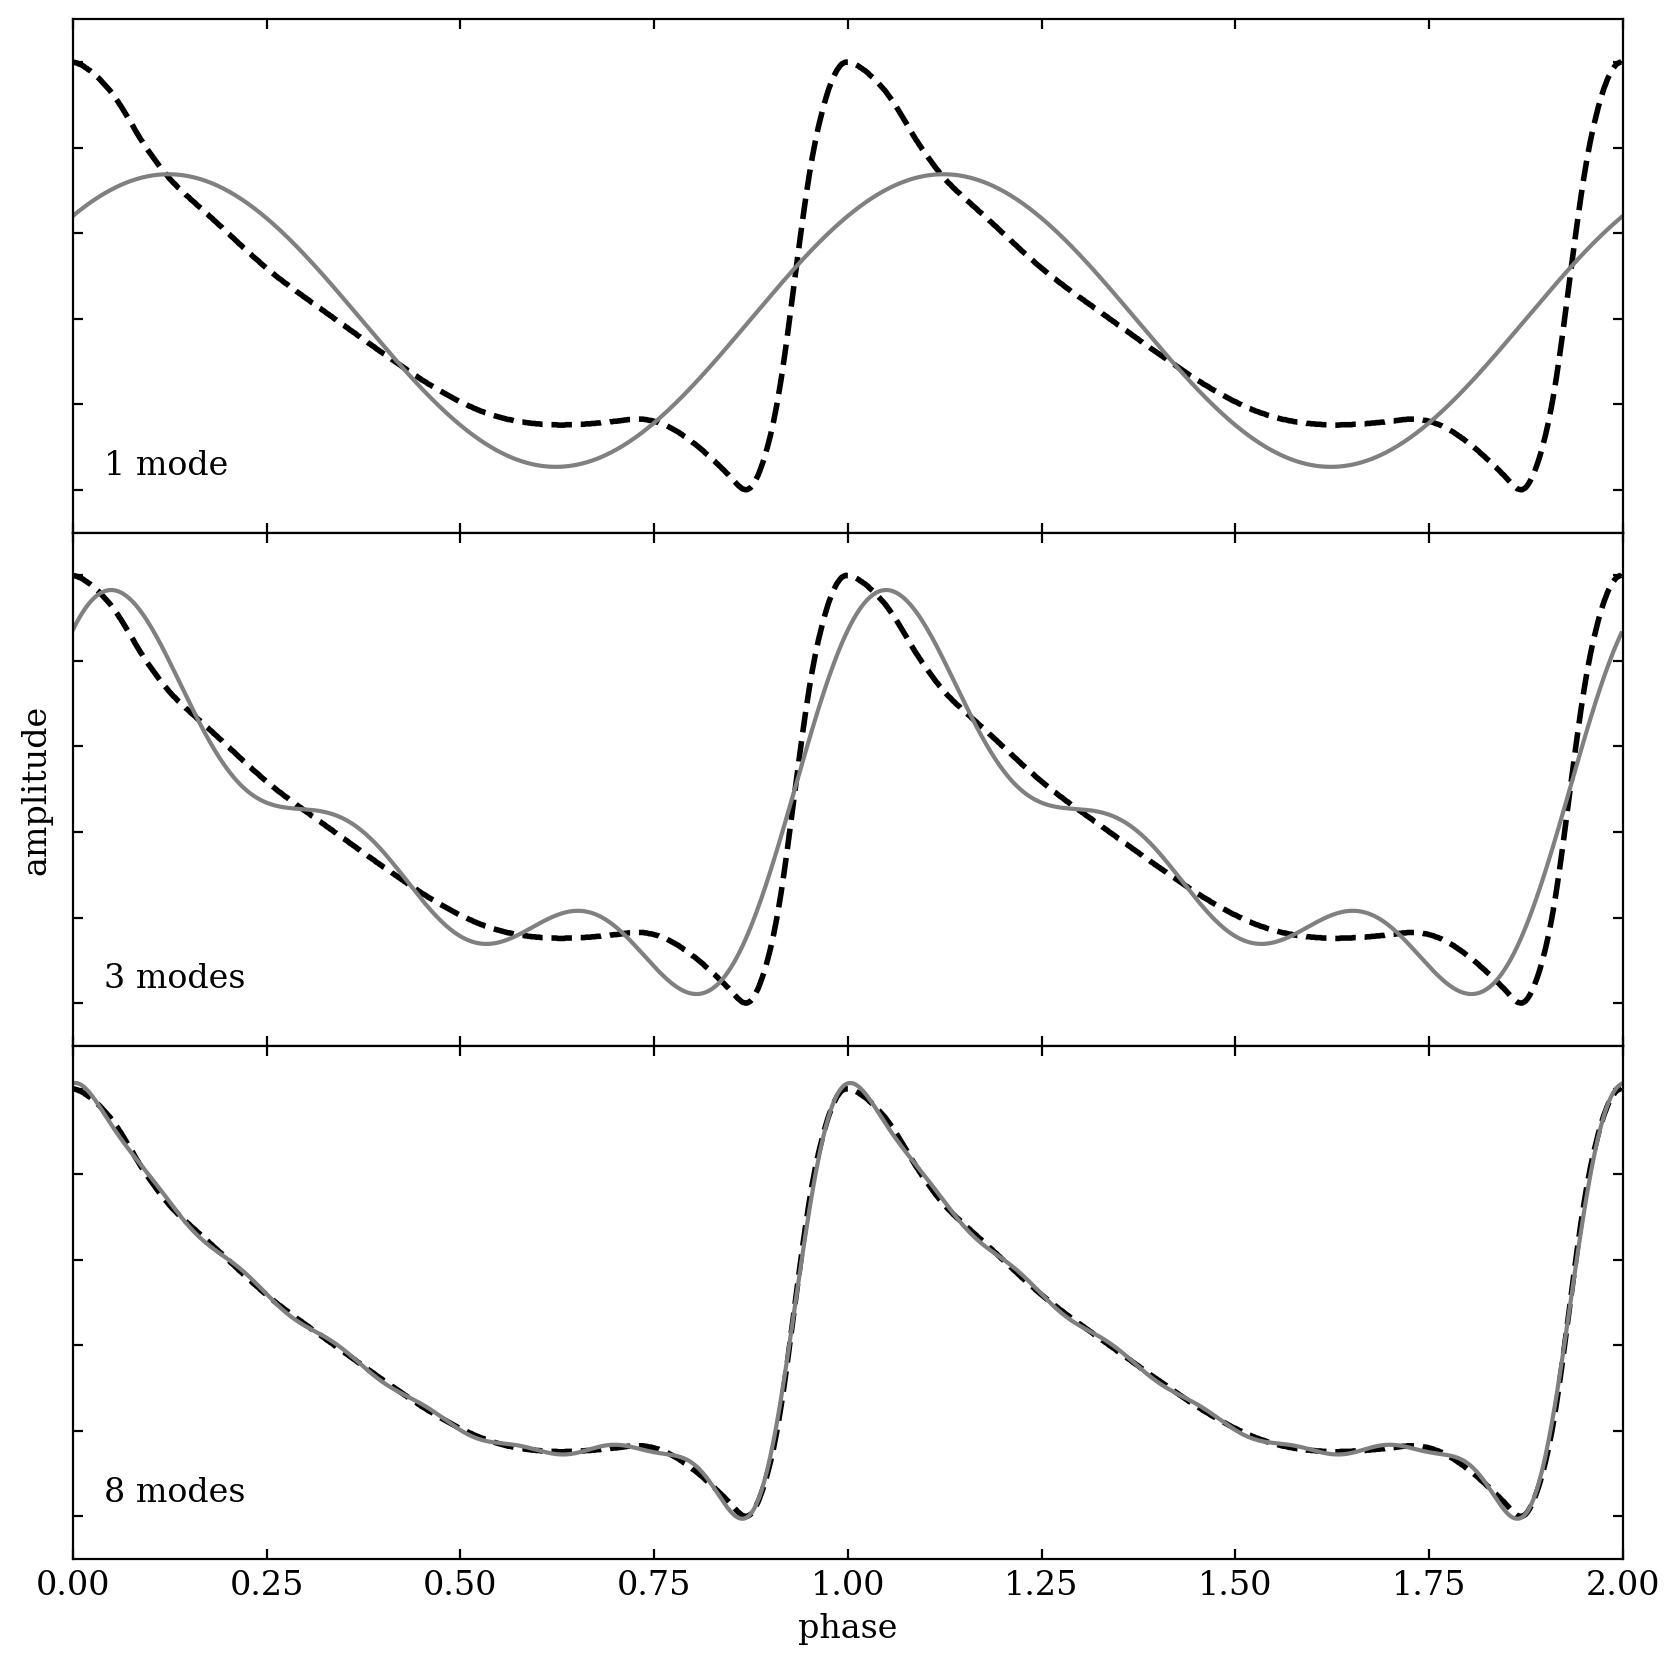

In [3]:
# Ivezic v2, Figure 10.1, edits by GTR and SRT
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from astroML.datasets import fetch_rrlyrae_templates

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=False)

#------------------------------------------------------------
# Load the RR Lyrae template
templates = fetch_rrlyrae_templates()
x, y = templates['115r'].T

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0)

kvals = [1, 3, 8] # number of modes/frequencies in Fourier transform
subplots = [311, 312, 313]

for (k, subplot) in zip(kvals, subplots):
    ax = fig.add_subplot(subplot)

    # Use FFT to fit a truncated Fourier series
    y_fft = np.fft.fft(y) # fourier transform data
    y_fft[k + 1:-k] = 0 # truncate to only include frequencies you want
    y_fit = np.fft.ifft(y_fft).real # inverse transform to see time-domain model

    # plot the true value and the k-term reconstruction
    ax.plot(np.concatenate([x, 1 + x]),
            np.concatenate([y, y]), '--k', lw=2)
    ax.plot(np.concatenate([x, 1 + x]),
            np.concatenate([y_fit, y_fit]), color='gray')

    label = "%i mode" % k
    if k > 1:
        label += 's'

    ax.text(0.02, 0.1, label, ha='left', va='bottom',
            transform=ax.transAxes)

    if subplot == subplots[-1]:
        ax.set_xlabel('phase')
    else:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    if subplot == subplots[1]:
        ax.set_ylabel('amplitude')
    ax.yaxis.set_major_formatter(plt.NullFormatter())

    ax.set_xlim(0, 2)
    ax.set_ylim(1.1, -0.1)

plt.show()

The Fourier Transform can be powerful if the signal-to-noise is high, but **if the S/N is low or if the signal has a complex shape or is irregularly sampled, then a probabilistic approach is better**.  In astronomy, that is often the situation that we find ourselves in. So, I'll leave the details for you to read about in $\S$ 10.2 and we'll skip ahead.

## Temporally Localized Signals <a class="anchor" id="four"></a>

Let's look at the case of a stationary signal with an event localized in time.
An example would be the signature of a [gravitational wave from LIGO](https://www.ligo.caltech.edu/news/ligo20160615), which looks like the following at different stages of the binary coalescence (image credit: Frans Pretorius, APS/Carin Cain):

![](https://physics.aps.org/assets/8c60cd69-5366-49d1-b1cf-53fce4303a14/e52_2.png)

In this case we know the expected shape of the signal and the noise properties are understood, so we can do what is called ***forward modeling***. Specifically, we can identify the signal by using a **matched filter** (with MCMC to search for the parameter covariances).

Even if we didn't know the shape of the distribution, we could use a non-parametric model to perform matched filter analysis (e.g. using basis shapes to reconstruct the signal). Furthermore, for complex signals we can marginalize over "nuisance" parameters (e.g. start time or phase) that are not important for our model.

### Finding a chirp or burst in a time series

Imagine a stationary signal $y(t)=b_0+\epsilon$ with an injected signal at time $T$ (possibly followed by a decay to the original level $b_0$ over some unknown time period). *(Sound familiar? Yeah, you already did some of this in a homework!)*

This injected signal could be a "burst" ((exponential decay after a sharp increase at $t=T$):

$$y(t)=b_0 + A\exp[−\alpha(t−T)]$$ 

or a ["chirp"](https://en.wikipedia.org/wiki/Chirp) (a periodic signal where the frequency changes with time):

$$y(t)=b_0+A \sin[\omega t+\beta t^2].$$

***Below are examples of using MCMC to fit both a burst signal and a chirp signal.*** You've done the first one before, but perhaps not with PyMC3. Try changing the parameters such that the system is 1) very well modeled and 2) very poorly modeled. See `###` below for where to alter the code.

@pickle_results: computing results and saving to 'matchedfilt_burst.pkl'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b0, A, T, log_alpha]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 172 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


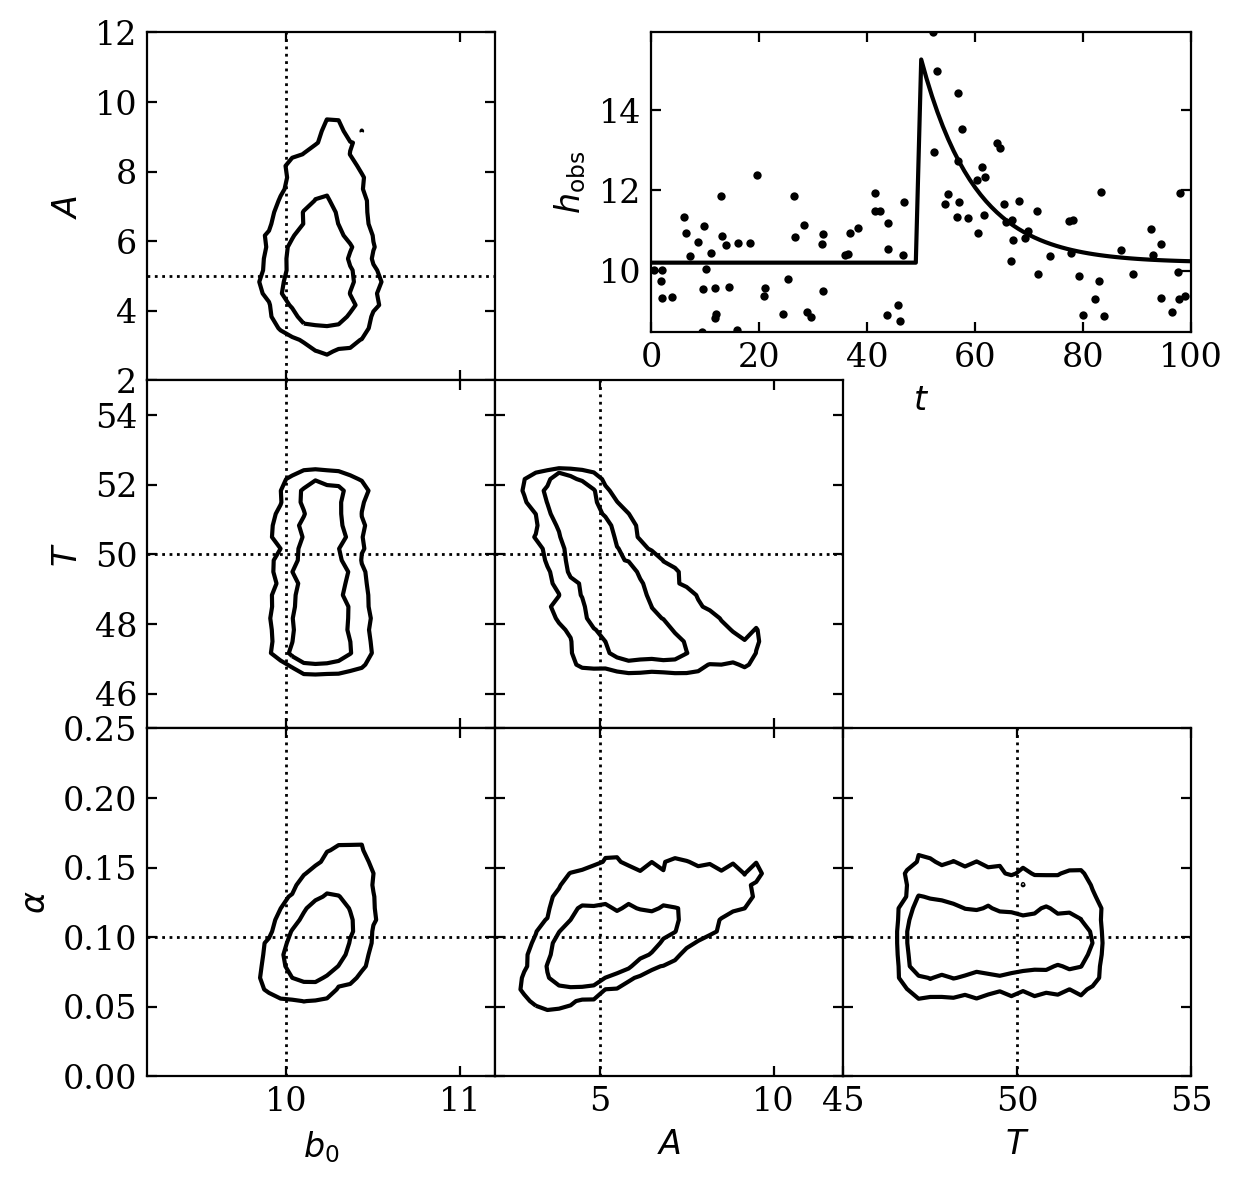

In [4]:
# Ivezic v2, Figure 10.25, edits by GTR and SRT
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import pymc as pm
from astroML.plotting.mcmc import plot_mcmc
from astroML.utils.decorators import pickle_results

# ----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=False)

# ----------------------------------------------------------------------
# Set up toy dataset
def burst(t, b0, A, alpha, T):
    """Burst model"""
    mask = (t >= T)
    y = b0 + mask * A * np.exp(-alpha * (t - T))
    return y

np.random.seed(0)

### See what happens when you change these.
### But don't pick values outside the limits searched by the MCMC
N = 100
b0_true = 10
A_true = 5
alpha_true = 0.1
T_true = 50
sigma = 1.0

t = 100 * np.random.random(N)

y_true = burst(t, b0_true, A_true, alpha_true, T_true)
y_obs = np.random.normal(y_true, sigma)

# ----------------------------------------------------------------------
# Set up and run the MCMC sampling
# We need to wrap it in a function in order to be able to pickle the result
@pickle_results('matchedfilt_burst.pkl')
def compute_MCMC_results(draws=3000, tune=1000):
    with pm.Model():
        # Prior Limits of MCMC model
        b0 = pm.Uniform('b0', 0, 50)
        A = pm.Uniform('A', 0, 50)
        T = pm.Uniform('T', 0, 100)
        log_alpha = pm.Uniform('log_alpha', -10, 10)

        y = pm.Normal('y', mu=burst(t, b0, A, np.exp(log_alpha), T),
                      sigma=sigma, observed=y_obs)

        traces = pm.sample(draws=draws, tune=tune)

        return traces


traces = compute_MCMC_results()
mean_vals = {}
for key in ['b0', 'A', 'T', 'log_alpha']:
    mean_vals.update({key: np.mean(traces.posterior[key].values)})
mean_vals['alpha'] = np.exp(mean_vals.pop('log_alpha'))

labels = ['$b_0$', '$A$', '$T$', r'$\alpha$']

limits = [(9.2, 11.2), (2, 12), (45, 55), (0.0, 0.25)]
true = [b0_true, A_true, T_true, alpha_true]

# ------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(bottom=0.1, top=0.95,
                    left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc(np.array([traces.posterior[i].values.flatten() for i in ['b0', 'A', 'T']] 
                   + [np.exp(traces.posterior['log_alpha'].values.flatten())]),
          labels=labels, limits=limits,
          true_values=true, fig=fig, bins=30, colors='k')

# Plot the model fit
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
t_fit = np.linspace(0, 100, 101)
y_fit = burst(t_fit, **mean_vals)

ax.scatter(t, y_obs, s=9, lw=0, c='k')
ax.plot(t_fit, y_fit, '-k')
ax.set_xlim(0, 100)
ax.set_xlabel('$t$')
ax.set_ylabel(r'$h_{\rm obs}$')

plt.show()

This example now shows fitting a chirping signal to time-series data. It's not totally like LIGO data analysis, because there not only does the frequency of the signal increase with time, but the amplitude also increases in tune with the frequency.

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [b0]
>Metropolis: [A]
>Metropolis: [log_beta]
>Metropolis: [log_omega]


/Users/howarn1/anaconda3/envs/astr8070/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


/Users/howarn1/anaconda3/envs/astr8070/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/Users/howarn1/anaconda3/envs/astr8070/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/Users/howarn1/anaconda3/envs/astr8070/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 2 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. 

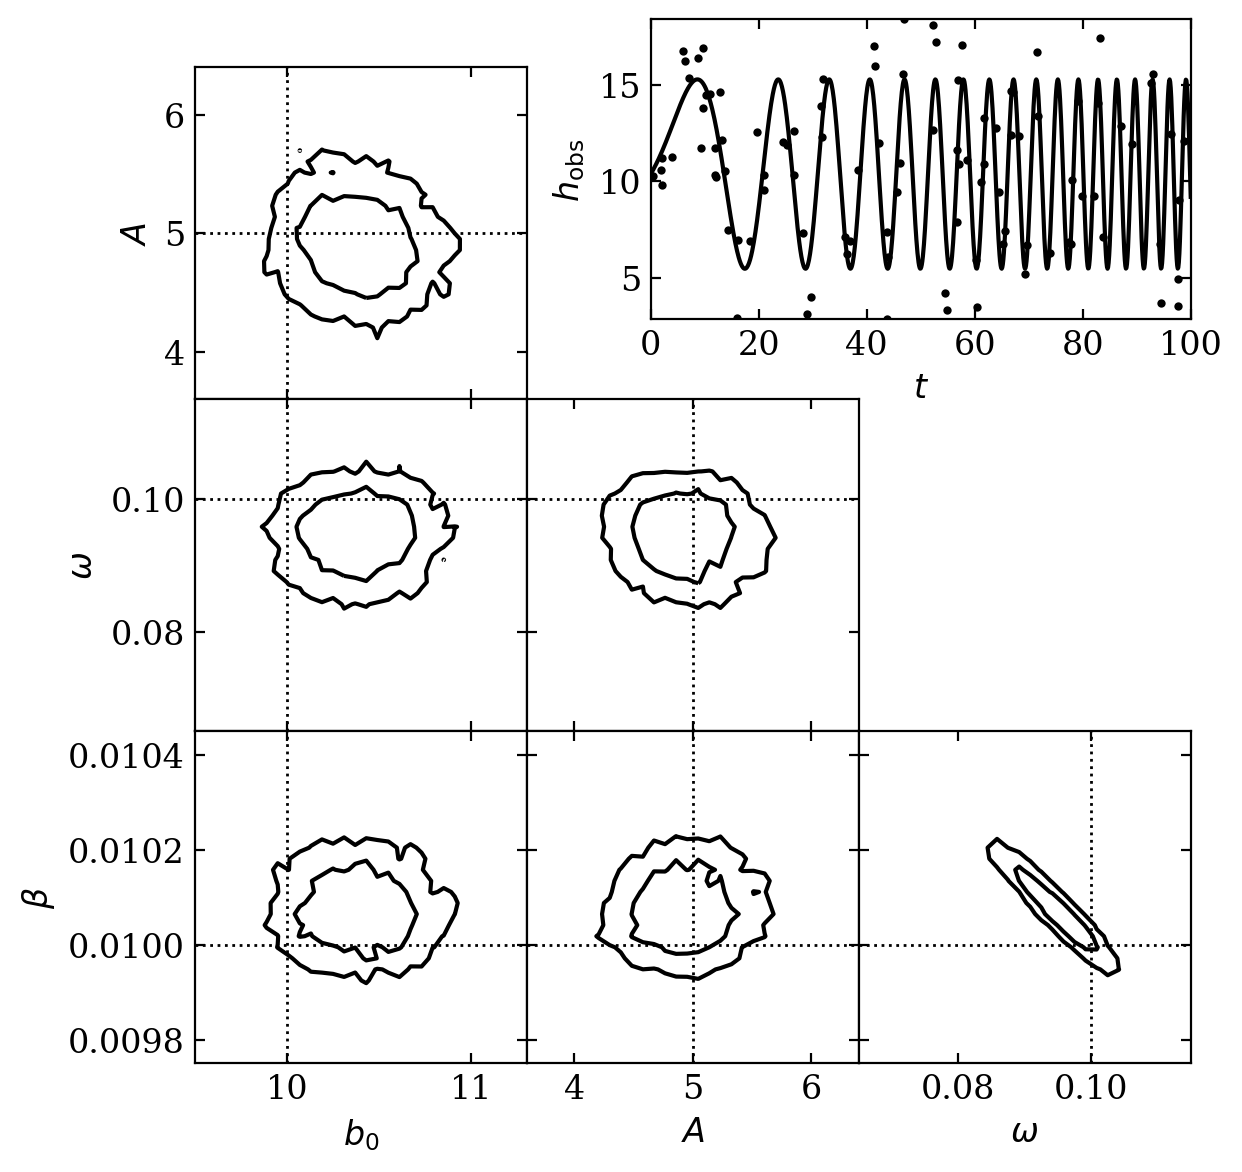

In [6]:
# Ivezic v2, Figure 10.26, edits by GTR and SRT
# Author: Jake VanderPlas (adapted to PyMC3 by Brigitta Sipocz)
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import pymc as pm
from astroML.plotting.mcmc import plot_mcmc

# ----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=False)

# ----------------------------------------------------------------------
# Set up toy dataset
def chirp(t, b0, beta, A, omega):
    return b0 + A * np.sin(omega * t + beta * t * t)

np.random.seed(0)

### See what happens when you change these.
### But don't pick values outside the limits searched by the MCMC
N = 100
#N = 1000
b0_true = 10
A_true = 5
beta_true = 0.01
omega_true = 0.1
#omega_true = 0.5
sigma = 2.0

t = 100 * np.random.random(N)

y_true = chirp(t, b0_true, beta_true, A_true, omega_true)
y_obs = np.random.normal(y_true, sigma)

# ----------------------------------------------------------------------
# Set up MCMC sampling
with pm.Model():
    # Limits of MCMC model
    b0 = pm.Uniform('b0', 0, 50, initval=50 * np.random.random())
    A = pm.Uniform('A', 0, 50, initval=50 * np.random.random())
    log_beta = pm.Uniform('log_beta', -10, 10, initval=-4.6)
    log_omega = pm.Uniform('log_omega', -10, 10, initval=-2.3)

    y = pm.Normal('y', mu=chirp(t, b0, np.exp(log_beta), A, np.exp(log_omega)),
                  sigma=sigma, observed=y_obs)

    # Choose the Metropolis-Hastings step rather than rely on the default
    step = pm.Metropolis()
    traces = pm.sample(draws=5000, tune=2000, step=step)


# ----------------------------------------------------------------------
mean_vals = {}
for key in ['b0', 'A', 'log_beta', 'log_omega']:
    mean_vals.update({key: np.mean(traces.posterior[key].values)})
mean_vals['omega'] = np.exp(mean_vals.pop('log_omega'))
mean_vals['beta'] = np.exp(mean_vals.pop('log_beta'))

labels = ['$b_0$', '$A$', r'$\omega$', r'$\beta$']
limits = [(9.5, 11.3), (3.6, 6.4), (0.065, 0.115), (0.00975, 0.01045)]
true = [b0_true, A_true, omega_true, beta_true]

fig = plt.figure(figsize=(6, 6))
ax = plt.axes([0.5, 0.7, 0.45, 0.25])

t_fit = np.linspace(0, 100, 1001)
y_fit = chirp(t_fit, **mean_vals)

# ----------------------------------------------------------------------
# Plot multiple panels with the traces
plt.scatter(t, y_obs, s=9, lw=0, c='k')
plt.plot(t_fit, y_fit, '-k')
plt.xlim(0, 100)
plt.xlabel('$t$')
plt.ylabel(r'$h_{\rm obs}$')

plot_mcmc(np.array([traces.posterior[ii].values.flatten() for ii in ['b0', 'A']]
          + [np.exp(traces.posterior['log_omega'].values.flatten()), np.exp(traces.posterior['log_beta'].values.flatten())]),
          labels=labels, limits=limits, true_values=true, fig=fig,
          bins=30, bounds=[0.12, 0.08, 0.95, 0.91], colors='k')
plt.show()

## Periodic signals <a class="anchor" id="five"></a>

Many systems have **periodic** signals.  This is especially true in astrophysics (e.g., pulsars, RR-Lyrae, Cepheids, eclipsing binaries, and perhaps periodically variable AGN).

> *We want to be able to detect variability, and measure the period and amplitude in the face of both noisy and incomplete data.*

If the data well-samples the process (high "cadence" of observations relative to the period), then determining the parameters of the process is easy. But...if the data are not well sampled, the job is harder (but still possible!). 

For example, the figure on top for RR Lyrae is the kind of data that you *want* to have, whereas the figure on the bottom is the kind of data that you are more likely to have.

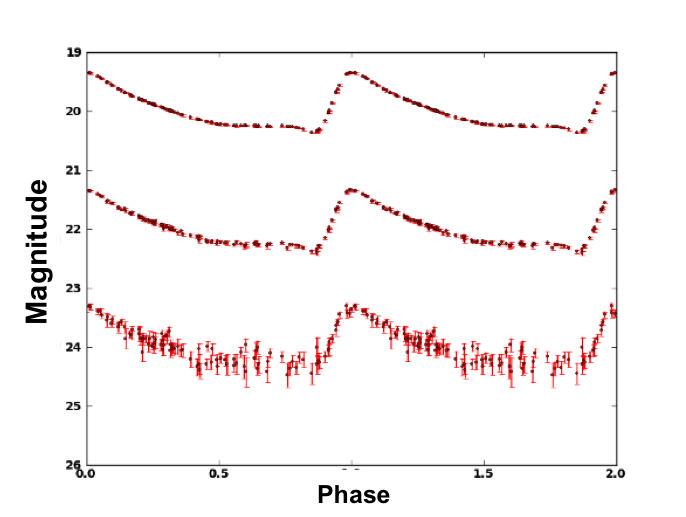
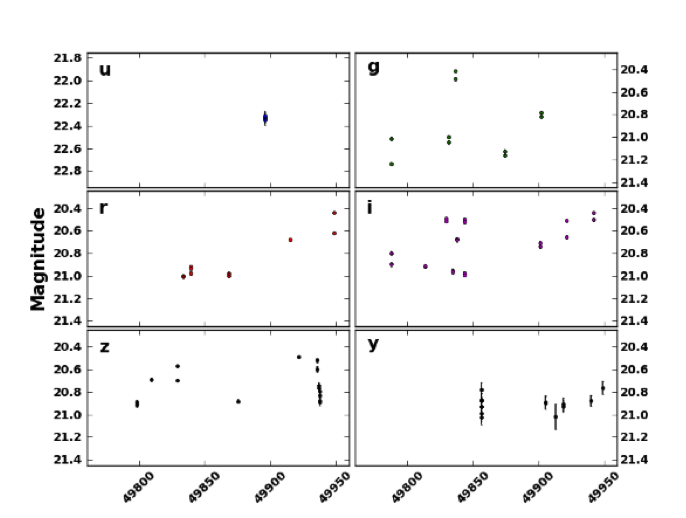

For a periodic signal:

- we can write $y(t+P)=y(t),$ where $P$ is the period.
- we can create a ***phased light curve*** that plots the data as function of phase: $\phi=\frac{t}{P} − {\rm int}\left(\frac{t}{P}\right)$.
- ${\rm int}(x)$ returns the integer part of $x$.

For example in the case below, when the pattern starts to repeat, we reset the $t$ axis to 0:

![Eclipsing Binary](https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Light_curve_of_binary_star_Kepler-16.jpg/800px-Light_curve_of_binary_star_Kepler-16.jpg)

### A Single Sinusoid

Let's take the case where the **data are drawn from a single sinusoidal signal**:

$$y(t)=a \sin(\omega t)+b \cos(\omega t),$$

where $A=(a^2+b^2)^{1/2}$ and $\phi=\tan^{−1}(b/a)$

and determine whether or not the data are indeed consistent with periodic variability and, if so, what is the period.

Assuming constant uncertainties on the data, the likelihood for this model becomes,

$$L\equiv p({t,y}|\omega,a,b,\sigma)=\prod^N_{j=1}\frac{1}{\sqrt{2π}\sigma} \exp \left(\frac{−[y_j−a \sin(\omega t_j)−b \cos(\omega t_j)]}{2\sigma^2} \right), $$

where $y_i$ is the measurement (e.g., the brightness of a star) taken at time $t_i$.

Remember, we can easily write the above because
- we assume Gaussian uncertainties on each observation.
- the uncertainties are given by **DATA MINUS MODEL**, which is what you have in the Gaussian.
- in other words, the "model" is the mean of your Gaussian for each event. 

The posterior can be simplified to

$$p(\omega|\{t,y\}, \sigma) \propto \sigma^{−N} \exp \left(\frac{−NQ}{2\sigma^2} \right) \propto \exp \left(\frac{P(\omega)}{\sigma^2} \right).$$

where $P(\omega)$ is the **[periodogram](https://en.wikipedia.org/wiki/Periodogram)**, which is just a plot of the "***power***" in the time series at each possible period (as illustrated below):

![periodogram.png](https://www.astroml.org/_images/fig_LS_example_1.png)

The periodogram is defined as

$$ P(\omega) = \frac{1}{N} \left[ \left(\sum_{j=1}^N y_j\sin(\omega t_j) \right)^2 + \left(\sum_{j=1}^N y_j\cos(\omega t_j) \right)^2 \right]$$

The "best value" $\omega$ is given by

$$\chi^2(\omega) =  \chi_0^2 \, \left[1 - {2 \over N \, V}  \, P(\omega) \right],$$

where $P(\omega)$ is the periodogram and $\chi_0^2$ is the $\chi^2$ for the null-hypothesis model with $y(t)$ = constant:

$$  \chi_0^2 = {1 \over \sigma^2} \sum_{j=1}^N y_j^2 = {N \, V \over \sigma^2}$$

We can renormalise the periodogram, defining the **[Lomb-Scargle periodogram](https://en.wikipedia.org/wiki/Least-squares_spectral_analysis#The_Lomb.E2.80.93Scargle_periodogram)** as

$$P_{\rm LS}(\omega) = \frac{2}{N V} P(\omega),$$  

where $$0 \le P_{\rm LS}(\omega) \le 1.$$

With this renormalization, the ratio of $\chi^2(\omega)$ ***(for the periodic model)*** 
relative to $\chi^2_0$ ***(for the pure noise model)*** is

$${\chi^2(\omega) \over \chi^2_0}=  1 - P_{LS}(\omega).$$

To determine if our source is variable or not, we first compute $P_{\rm LS}(\omega)$ and then model the odds ratio for our variability model vs. a no-variability model. If our variability model is "correct", then the peak of $P(\omega)$ [found by grid search] gives the best $\omega$.

Below is an example of a LS periodogram generated using 100 points drawn from $y(t|P) = 10 + \sin(2\pi t/P),$ with $P=0.3$.  

[http://www.astroml.org/gatspy/periodic/lomb_scargle.html](http://www.astroml.org/gatspy/periodic/lomb_scargle.html) gives more information on astroML's implementation.

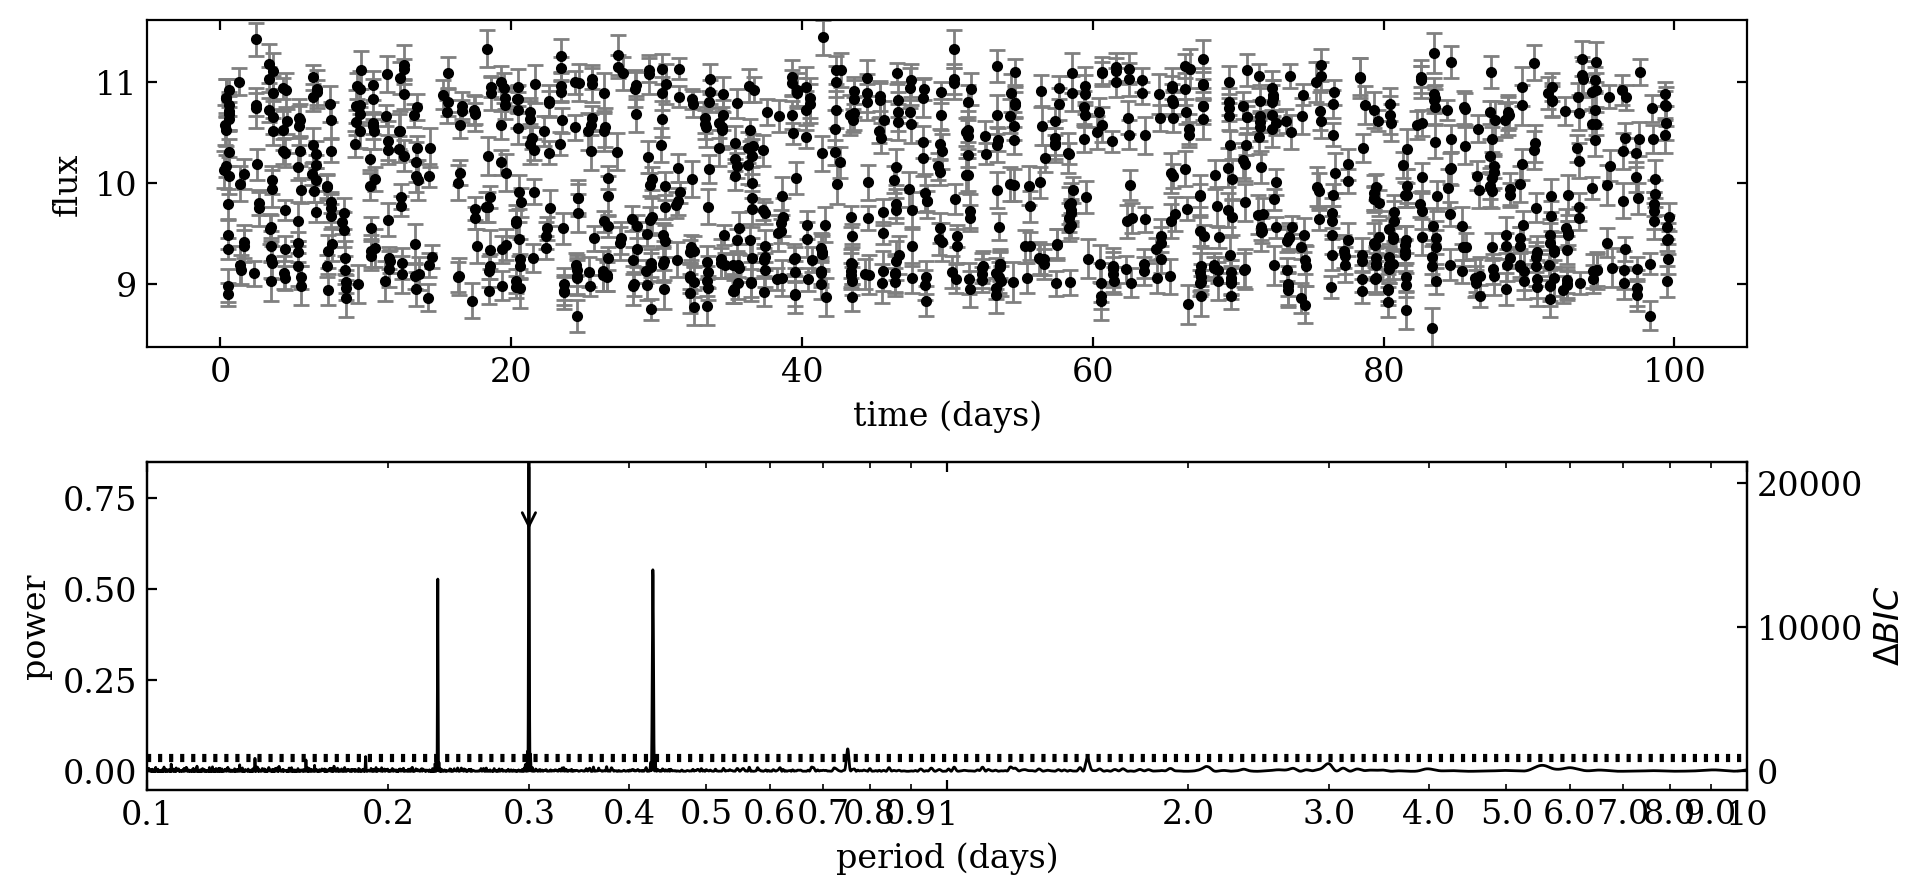

In [11]:
# Ivezic v2, Figure 10.15, edits by GTR (see UW AST324) and SRT
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from astroML.time_series import lomb_scargle_BIC
from astropy.timeseries import LombScargle

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=False)

#------------------------------------------------------------
# Generate Data
np.random.seed(0)
N = 1000
P = 0.3

t = np.random.randint(100, size=N) + 0.3 + 0.4 * np.random.random(N)
y = 10 + np.sin(2 * np.pi * t / P)
dy = 0.1 + 0.1 * np.random.random(N)
y_obs = np.random.normal(y, dy)

#------------------------------------------------------------
# Compute periodogram
period = 10 ** np.linspace(-1, 1, 10000)
omega = 1. / period
LS = LombScargle(t, y_obs, dy)
PS = LS.power(omega)

#------------------------------------------------------------
# Get significance via bootstrap
D = LS.false_alarm_level([0.01,0.001], method='bootstrap') 
sig1, sig5 = D[0], D[1]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(left=0.1, right=0.9, hspace=0.35)

# First panel: the data
ax = fig.add_subplot(211)
ax.errorbar(t, y_obs, dy, fmt='.k', lw=1, ecolor='gray')
ax.set_xlabel('time (days)')
ax.set_ylabel('flux')
ax.set_xlim(-5, 105)

# Second panel: the periodogram & significance levels
ax1 = fig.add_subplot(212, xscale='log')
ax1.plot(period, PS, '-', 
         c='black', lw=1, zorder=1)
ax1.plot([period[0], period[-1]], 
         [sig1, sig1], ':', c='black')
ax1.plot([period[0], period[-1]], 
         [sig5, sig5], ':', c='black')

ax1.annotate("", (0.3, 0.65), (0.3, 0.85), ha='center',
             arrowprops=dict(arrowstyle='->'))

ax1.set_xlim(period[0], period[-1])
ax1.set_ylim(-0.05, 0.85)

ax1.set_xlabel(r'period (days)')
ax1.set_ylabel('power')

# Twin axis: label BIC on the right side
ax2 = ax1.twinx()
ax2.set_ylim(tuple(lomb_scargle_BIC(ax1.get_ylim(), y_obs, dy)))
ax2.set_ylabel(r'$\Delta BIC$')

ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax1.xaxis.set_minor_formatter(plt.FormatStrFormatter('%.1f'))
ax1.xaxis.set_major_locator(plt.LogLocator(10))
ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.3g'))

plt.show()

If that isn't impressive, try changing the period to 5-10 days and the number of points to 200-300 (you'll need to increase `period` array as appropriate, note that it is a log quantity) to compare this to a situation that is more obvious.  Now are you impressed?

## Lomb-Scargle Periodogram  <a class="anchor" id="six"></a>

Why do we care about the LS periodogram at all? 

> *The LS periodogram is the standard method to search for periodicity in unevenly-sampled time-series data.*

Unlike the Discrete Fourier Tranform (DFT), our data do not have to be evenly sampled for the LS periodogram to work and show a peak at the correct period. It can also account for heteroscedastic uncertainties. The full structure of the LS periodogram equations for heteroscedastic uncertainties are given in Section 10.3.2.

### False Alarm Probability

The **false alarm probability** tells us “what is the probability that a signal with no periodic component would lead to a peak of this magnitude?” (VanderPlas 2017, [arXiv:1703.09824](https://arxiv.org/abs/1703.09824)), but what we want to know is instead “what is the probability that this dataset is periodic given these
observations?”, which is 

$$ {p(\mathrm{Var}\,|\,\mathrm{Peak}) \over p(\mathrm{Const}\,|\,\mathrm{Peak})} = {1 \over \mathrm{FAP}} \, {p(\mathrm{Var}) \over p(\mathrm{Const})}. $$

In order to have a reliable detection of the period we want the odds ratio on the LHS $>$10. Depending on the ratio of priors [p(Var)/p(Const)], we determine the required FAP.

The two horizontal dashed lines in the periodogram above correspond to FAPs of 0.01 and 0.001 (computed from bootstrap resampling of the data).

### Aliasing

> *But why did we have 3 peaks above the line FAP=0.001???* 

The two most common problems are **[sampling aliases](https://www.wikiwand.com/en/Aliasing)** (e.g. observations spaced  by roughly 1 day) and **inability of a single sinusoid to fit the shape of light curve** (always check if there is another significant peak at twice the best-fit period). Given a set of time-series data with a certain cadence between observations, multiple sine waves could "fit" the pattern of data.

![](https://zone.ni.com/images/reference/en-XX/help/371361R-01/guid-932173fe-d89c-4bc0-a3ed-980f99bcc06b-help-web.png)

In photography, aliasing is called Moiré patterns:

![](https://distance.ufhealth.org/files/2016/06/moire-effect.jpg)

For details see Section 7.2 in "*Understanding the Lomb-Scargle Periodogram*"  by Jake VanderPlas (2017, [arXiv:1703.09824](https://arxiv.org/abs/1703.09824)). 


### Generalized Lomb-Scargle

The Lomb-Scargle periodogram is a fit to a model:

$$y(t)=a \sin(\omega t)+b \cos(\omega t),$$

whose mean is zero. In reality, the observed variability is typically around some (mean) value, not zero. We deal with this by subtracting the mean of the sample $\overline{y}$ from the data before performing the periodogram analysis.

That only works if $\overline{y}$ is a good estimator of the mean of the distribution, $y(t)$ -- if the data is equally sampled at all phases. However, in practice, the data may not equally sample all of the phases.

For example, consider the case of a star that has a period of one day and the fact that a single optical telescope only takes data at night. In that case you we might get something like the top panel below:

![Ivezic, Figure 10.16](http://www.astroml.org/_images/fig_LS_sg_comparison_3.png)

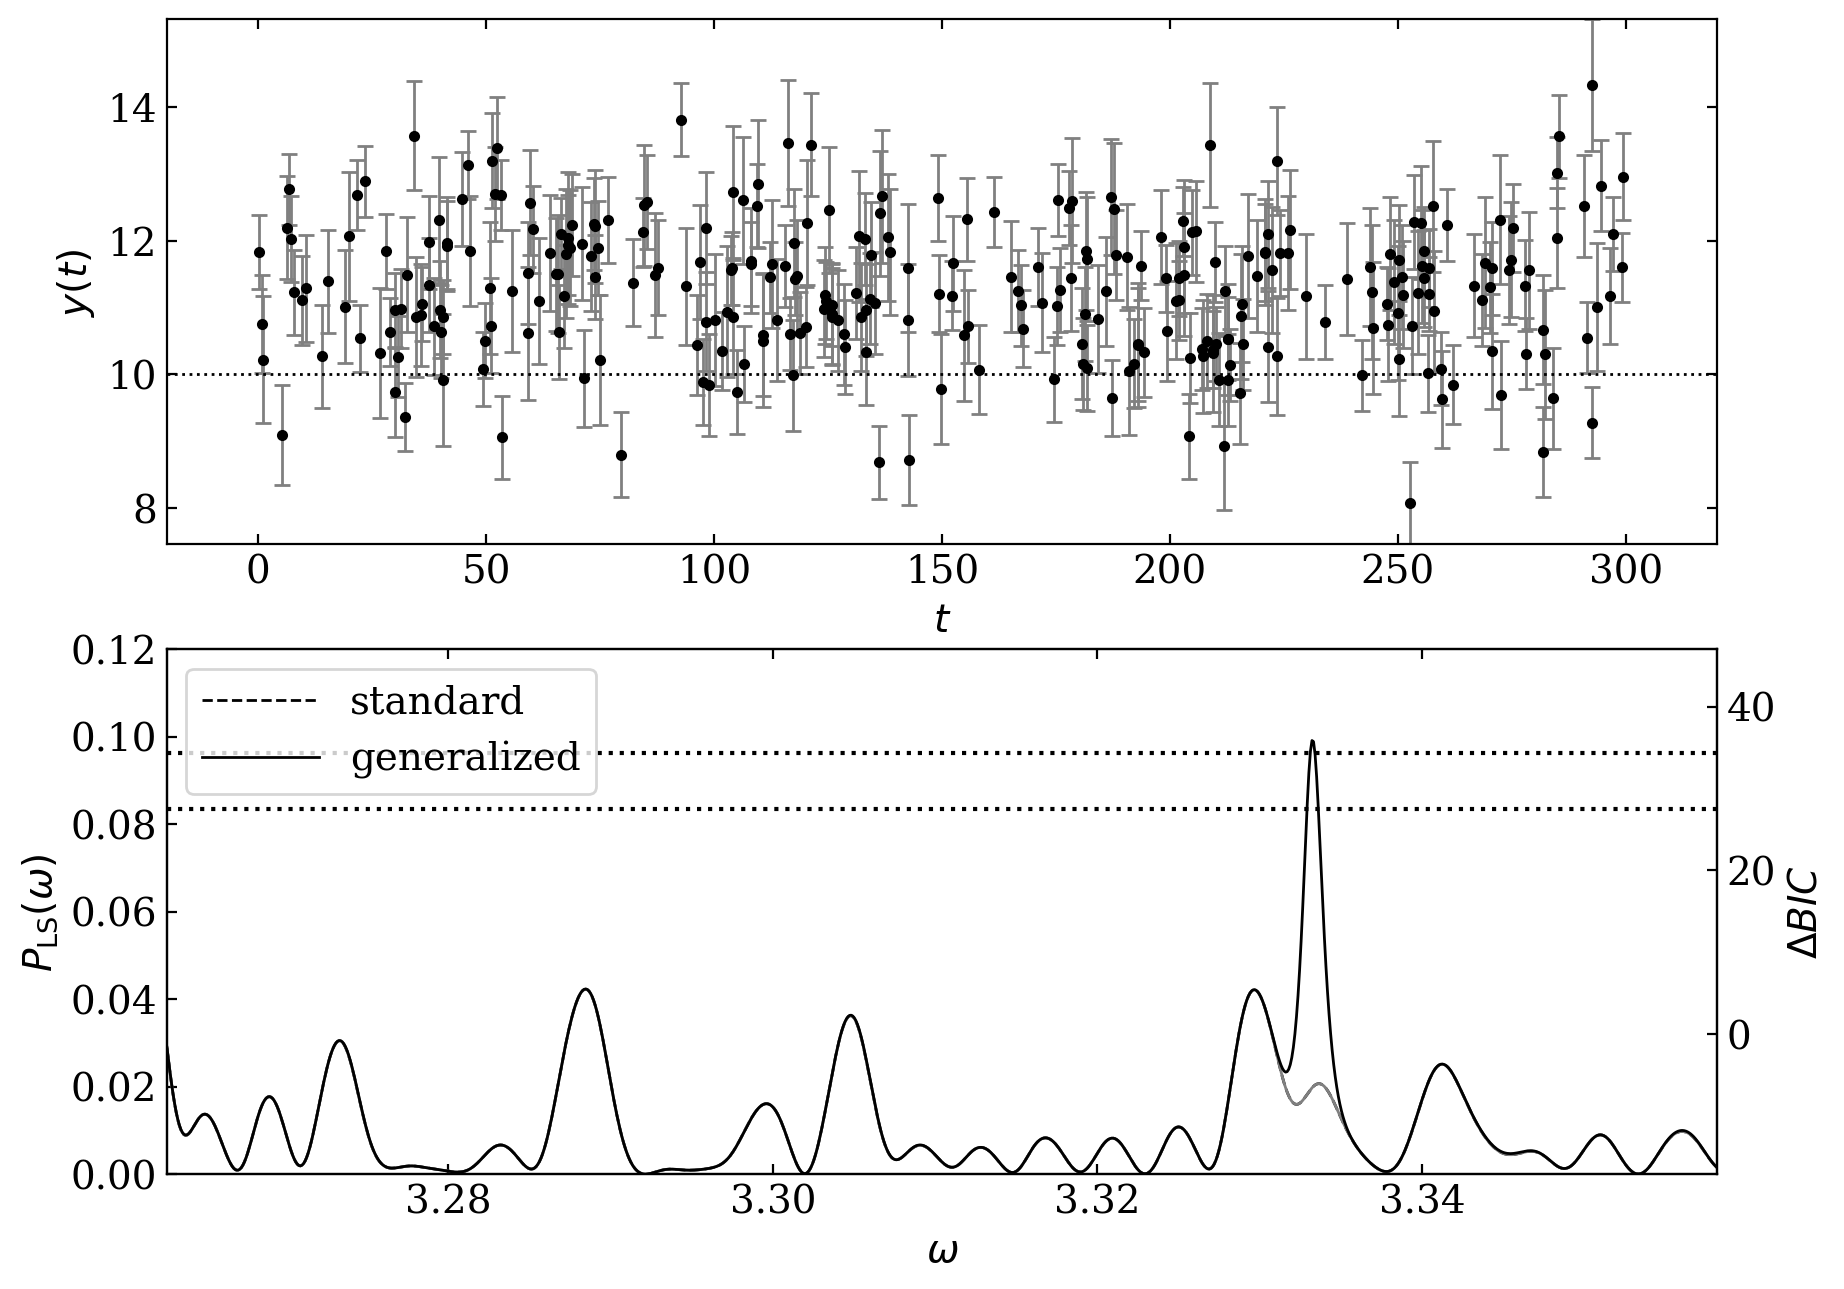

In [12]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from astroML.time_series import lomb_scargle_BIC
from astropy.timeseries import LombScargle

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=14, usetex=False)

#------------------------------------------------------------
# Generate data where y is positive
np.random.seed(0)
N = 300
P = 0.3

t = P / 2 * np.random.random(N) + P * np.random.randint(1000, size=N)
y = 10 + np.sin(2 * np.pi * t / P)
dy = 0.5 + 0.5 * np.random.random(N)
y_obs = y + np.random.normal(dy)

omega_0 = 1. / P


#------------------------------------------------------------
# Compute the Lomb-Scargle Periodogram
sig = np.array([0.1, 0.01, 0.001])
omega = np.linspace(20.5, 21.1, 1000) / 2.0 / np.pi

LS_S = LombScargle(t, y_obs, dy, fit_mean=False)
LS_G = LombScargle(t, y_obs, dy)

P_S = LS_S.power(omega)
P_G = LS_G.power(omega)

#------------------------------------------------------------
# Get significance via bootstrap
D = LS_G.false_alarm_level([0.01,0.05], method='bootstrap') 
sig1, sig5 = D[0], D[1]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5*2, 2*3.75))

# First panel: input data
ax = fig.add_subplot(211)
ax.errorbar(t, y_obs, dy, fmt='.k', lw=1, ecolor='gray')
ax.plot([-20, 320], [10, 10], ':k', lw=1)

ax.set_xlim(-20, 320)
ax.set_xlabel('$t$')
ax.set_ylabel('$y(t)$')

# Second panel: periodogram
ax = fig.add_subplot(212)
ax.plot(omega, P_S, '--k', lw=1, label='standard')
ax.plot(omega, P_S, '-', c='gray', lw=1)
ax.plot(omega, P_G, '-k', lw=1, label='generalized')
ax.legend(loc=2)

# plot the significance lines.
xlim = (omega[0], omega[-1])
ax.plot(xlim, [sig1, sig1], ':', c='black')
ax.plot(xlim, [sig5, sig5], ':', c='black')

# label BIC on the right side
ax2 = ax.twinx()
ax2.set_ylim(tuple(lomb_scargle_BIC(ax.get_ylim(), y_obs, dy)))
ax2.set_ylabel(r'$\Delta BIC$')

ax.set_xlabel('$\omega$')
ax.set_ylabel(r'$P_{\rm LS}(\omega)$')
ax.set_xlim(xlim)
ax.set_ylim(0, 0.12)

plt.show()

The ***Generalized Lomb-Scargle*** approach (also implemented in astroML) can help with this as can be seen in the bottom panel above. It fits the model with non-zero mean:

$$y(t)=a \sin(\omega t)+b \cos(\omega t) + C$$

See also [Figure 10.16](http://www.astroml.org/book_figures/chapter10/fig_LS_sg_comparison.html) in the textbook (and note the erratum!).

### Multiband LS periodograms

Related to this is that one of the issues that we are going to be dealing with in astronomy over the next decade as the LSST project comes online is the problem of sparsely-sampled light curves, but with multiple light curves for each object -- one for each "bandpass" as seen below:

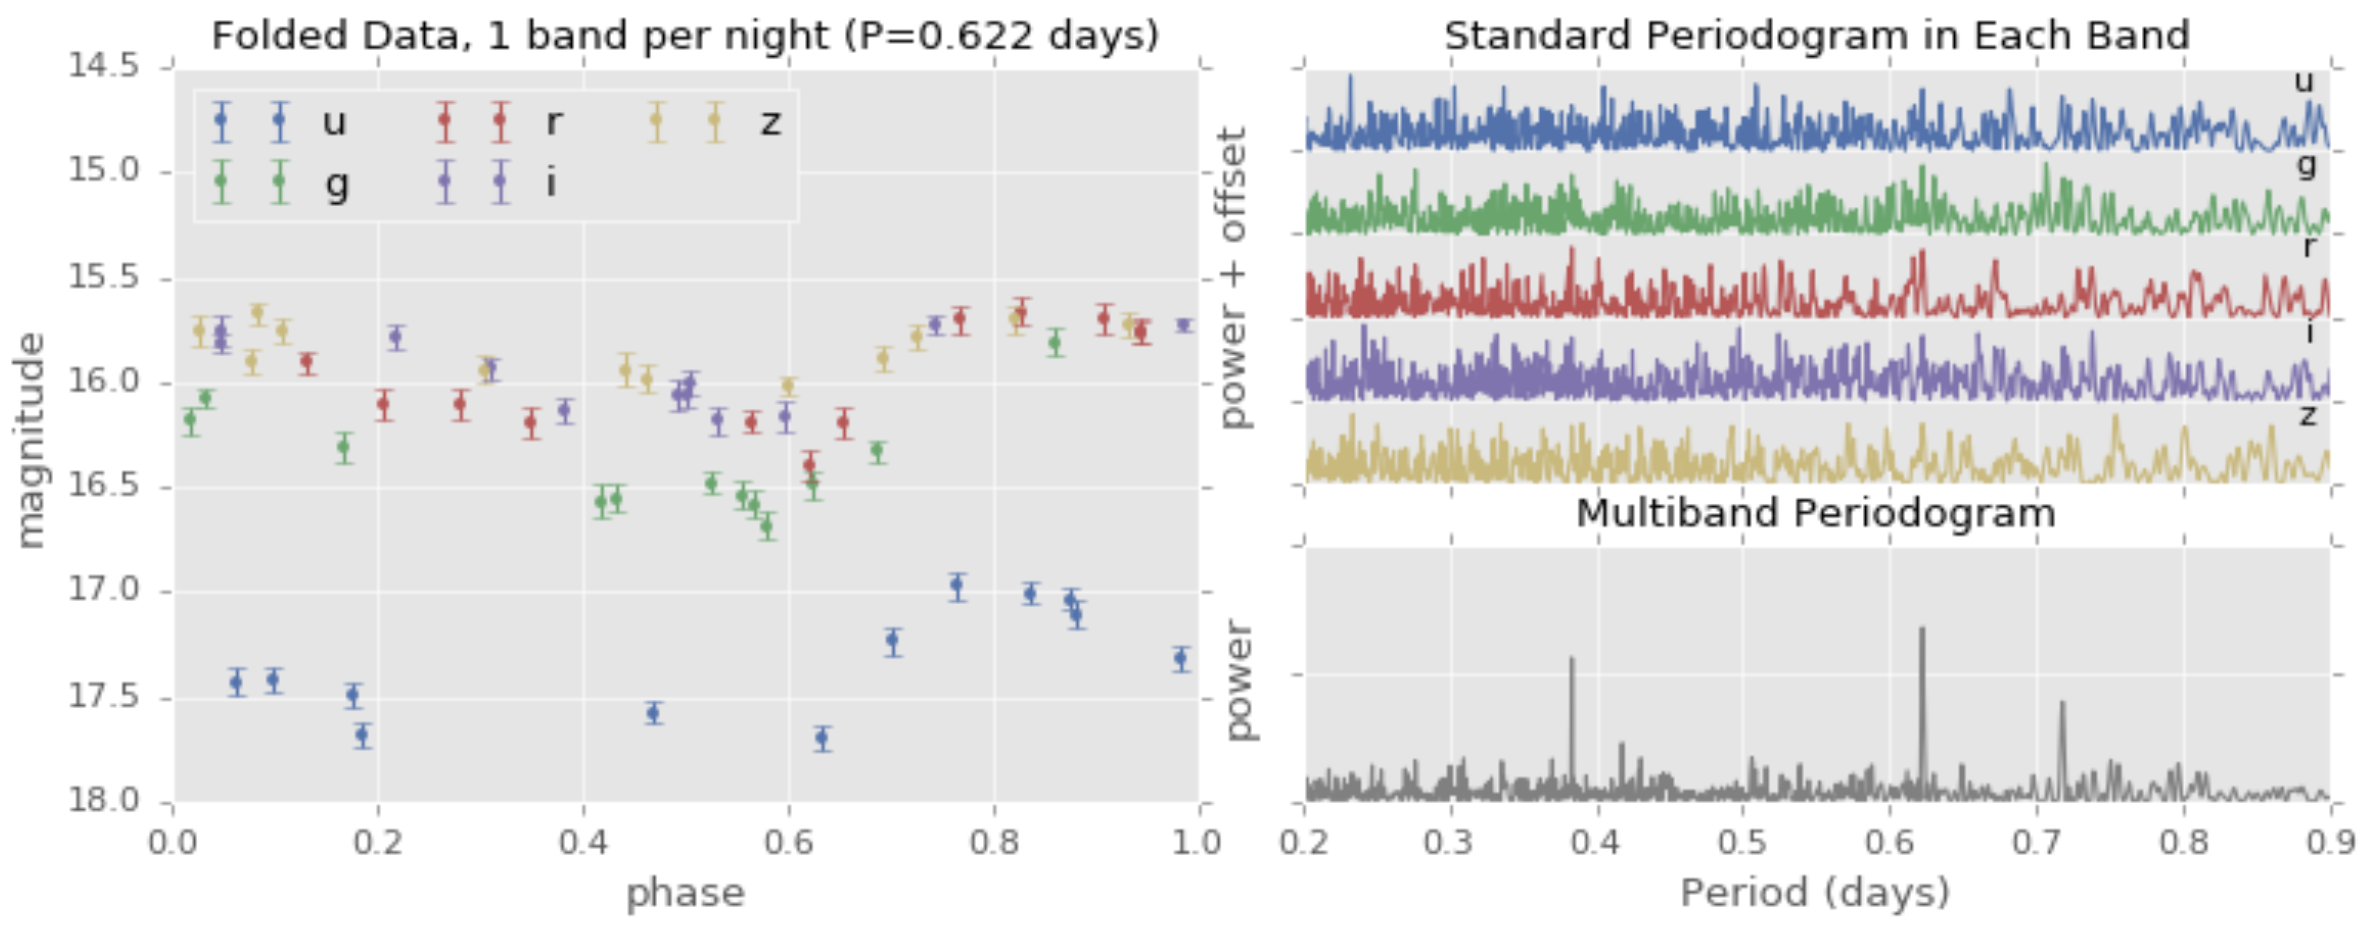

(figure from [here](https://www.astroml.org/gatspy/periodic/lomb_scargle_multiband.html))

The Generalized LS was an extension to account for the mean value. We can build on top of the Generalized LS to account for multiple bands by fitting for a global period and a per-band period (see pasted equation below this cell if it does not render in LaTex here...)

$$
\begin{eqnarray}
  &y_k(t|\omega,\theta) =
  \theta_0 + \sum_{n=1}^{N_{base}} \left[\theta_{2n - 1}\sin(n\omega t) + \theta_{2n}\cos(n\omega t)\right] +&\nonumber
  &\theta^{(k)}_0 + \sum_{n=1}^{N_{band}} \left[\theta^{(k)}_{2n - 1}\sin(n\omega t) + \theta^{(k)}_{2n}\cos(n\omega t)\right].&
\end{eqnarray}
$$

(Actually this illustrates a global offset and per-band offsets and not periods.)

The total number of parameters for $K$ filters is then $M_K = (2N_{base} + 1) + K(2N_{band} + 1)$. 

To keep the parameters constrained we apply regularization (e.g. ridge or lasso).

The important feature of this model is that **all bands** share the same base parameters, $\theta$, while their offsets $\theta^{(k)}$ are determined individually.

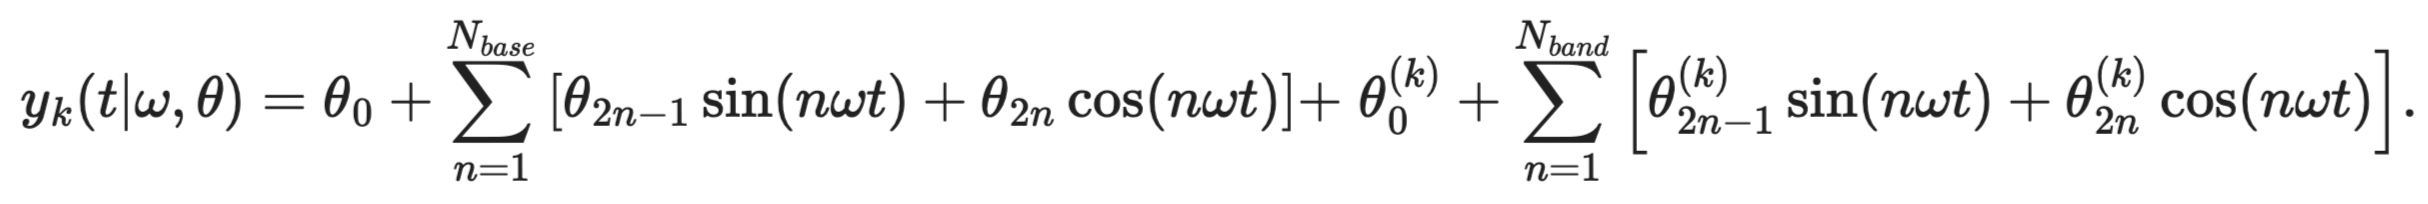

In [20]:
### Patch by Davide Gerosa. Files disappeared from the defaul URL. Manually downloaded from 
# https://github.com/astroML/astroML-data/tree/master/datasets/S82_RRLyr
#### into scripts. Set the following env variable:
%env ASTROML_DATA= /Users/howarn1/repos/astr_8070_s24/lectures/scripts

from gatspy.datasets import fetch_rrlyrae
from gatspy.periodic import LombScargleMultiband

rrlyrae = fetch_rrlyrae()
lcid = rrlyrae.ids[0]

t, y, dy, filts = rrlyrae.get_lightcurve(lcid)
period = rrlyrae.get_metadata(lcid)['P']

env: ASTROML_DATA=/Users/howarn1/repos/astr_8070_s24/lectures/scripts


This gives you time `t`, magnitude `y` and the filter `filts` of each datapoint. The `period` of the star has already been fitted (using e.g. and MCMC, see ao) by someone else.

In [21]:
set(filts)

{'g', 'i', 'r', 'u', 'z'}

This is how our data look like, which is kind of a mess.

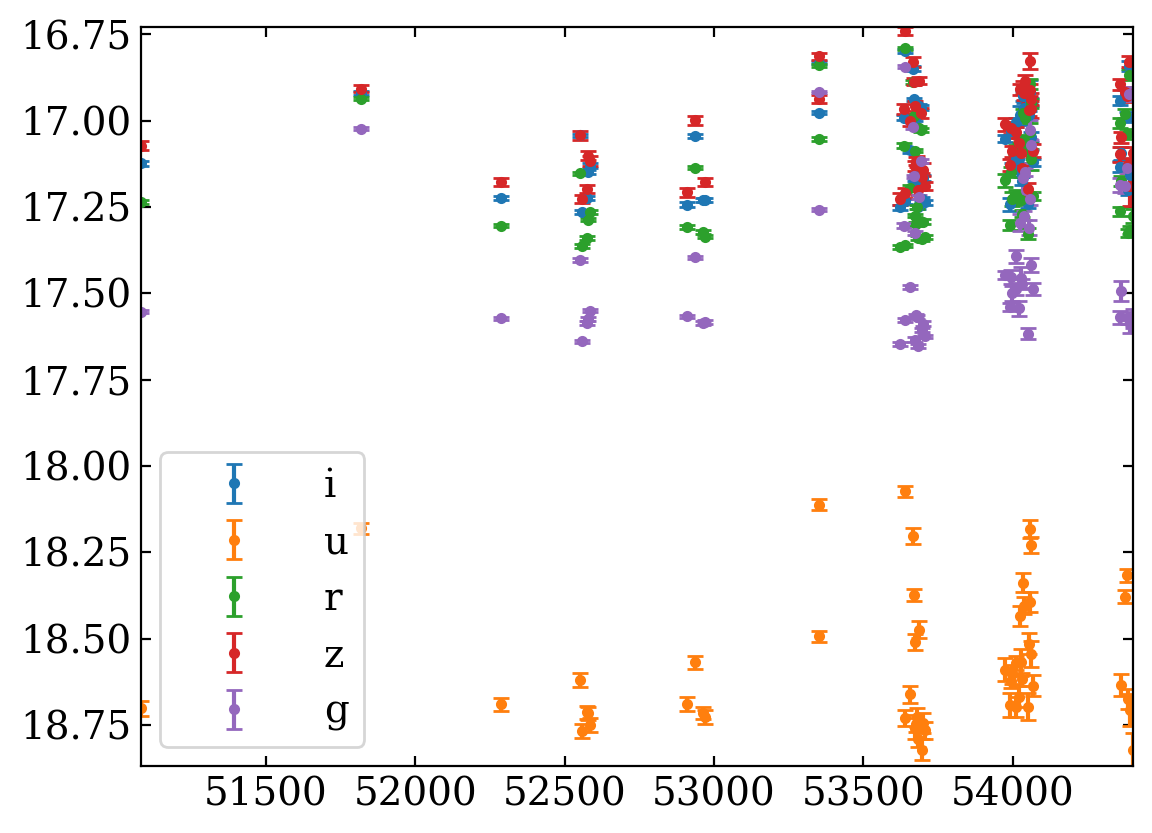

In [22]:
for filt in set(filts):
    mask = (filts == filt)
    plt.errorbar(t[mask], y[mask], dy[mask], fmt='.', label=filt)
        
plt.gca().invert_yaxis() ## Because magnitudes go the other way
plt.legend()

A fit with just one base term isn't so great:

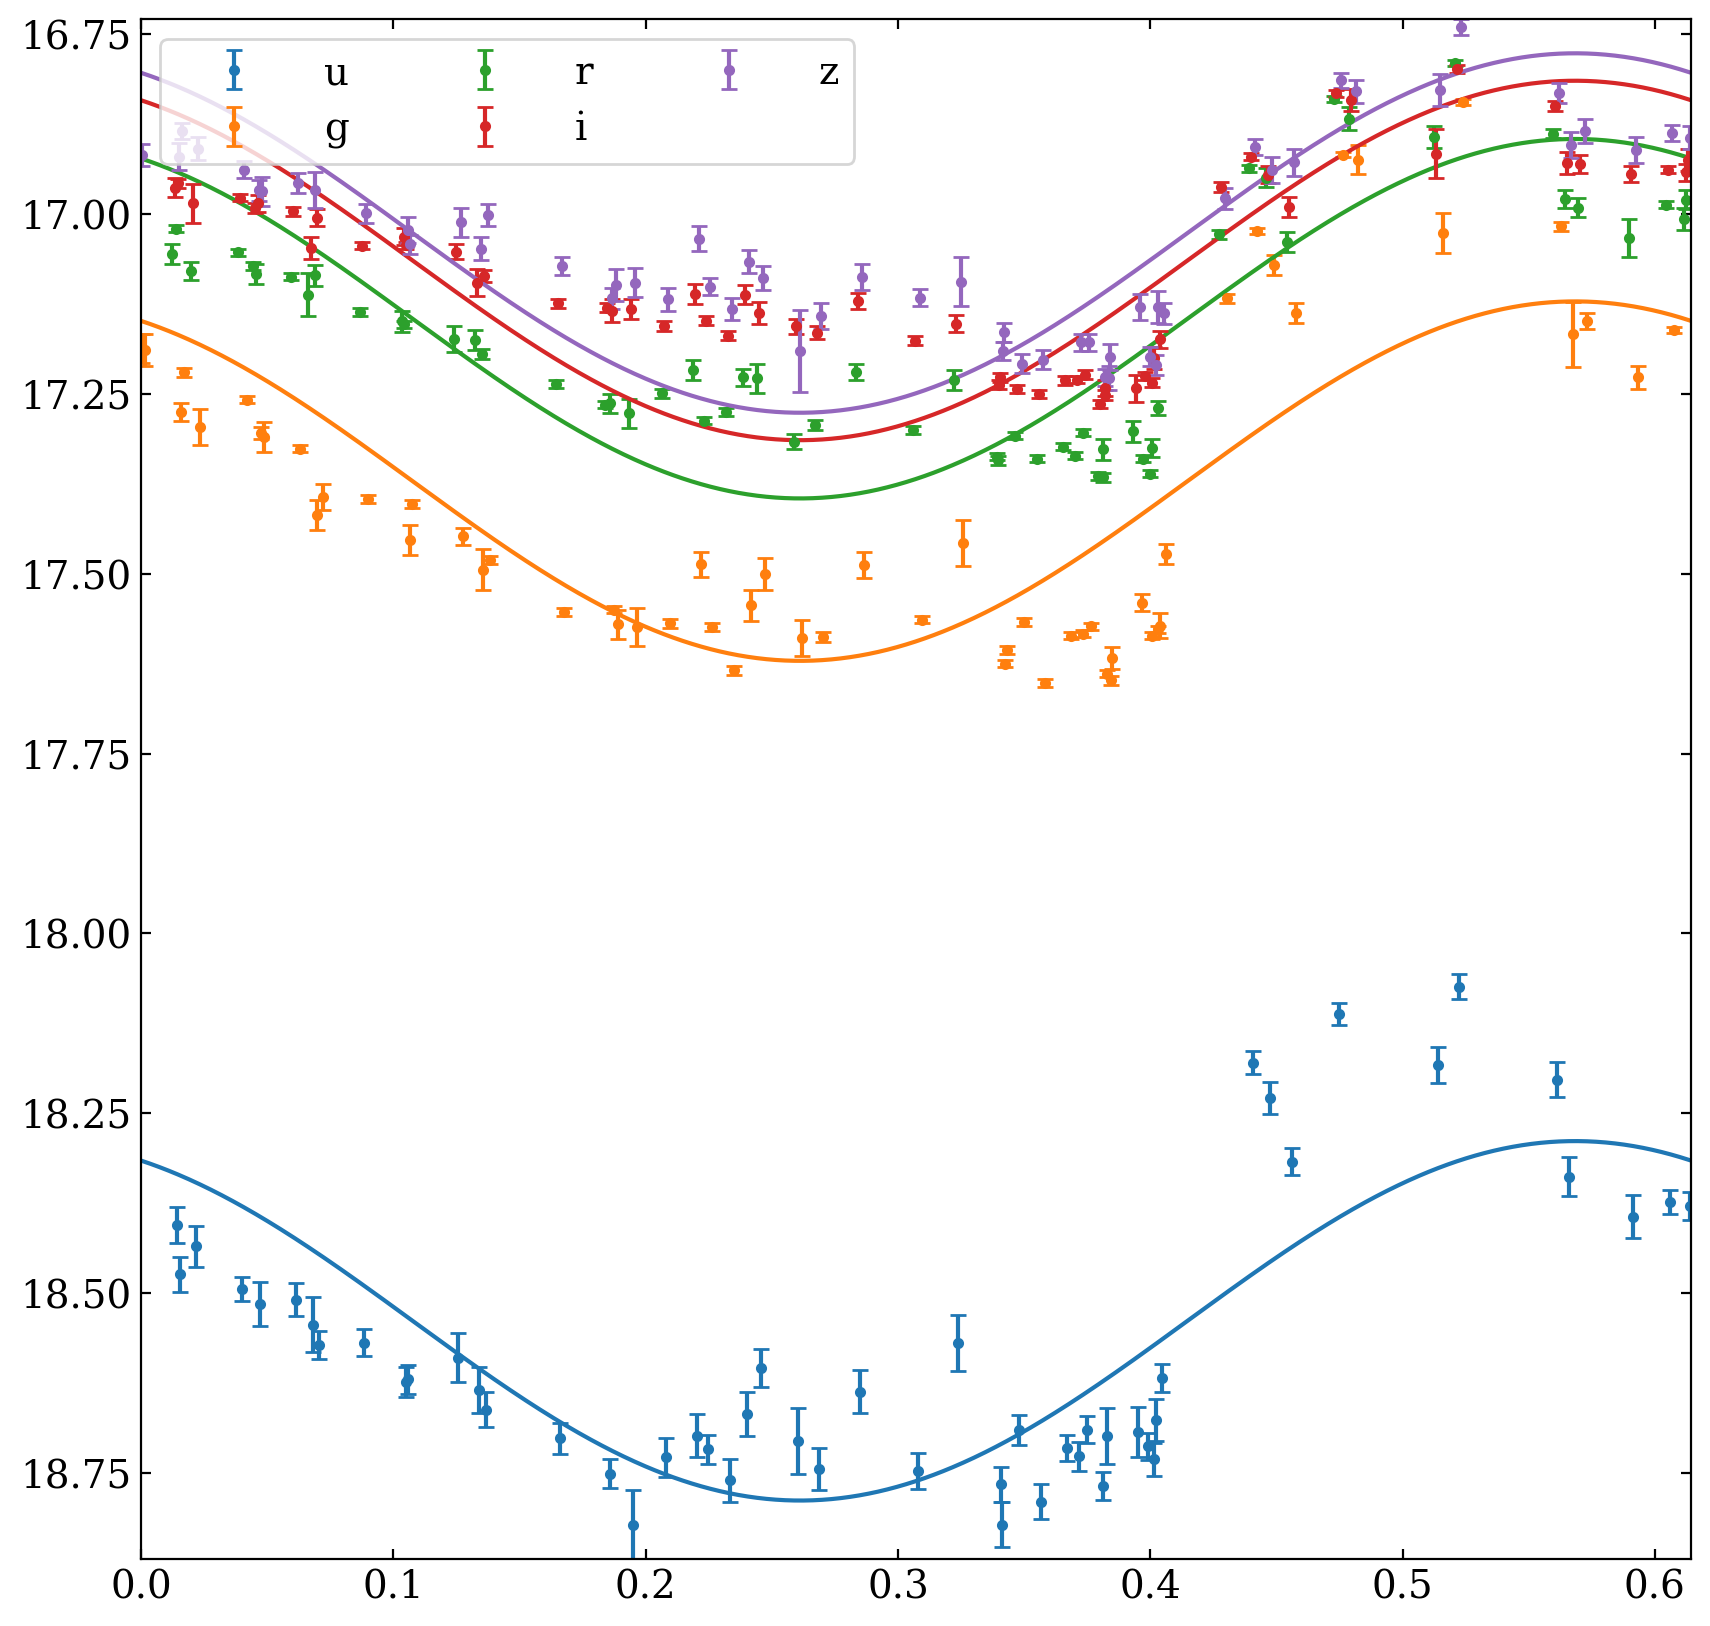

In [32]:
model = LombScargleMultiband(Nterms_base=4, Nterms_band=10)
model.fit(t, y, dy, filts)

periods = np.linspace(period - 0.1, period + 0.1, 2000)
power = model.periodogram(periods)

def plot_model(model, lcid):
    t, y, dy, filts = rrlyrae.get_lightcurve(lcid)
    model.fit(t, y, dy, filts)
    
    tfit = np.linspace(0, period, 1000)
    for filt in 'ugriz':
        mask = (filts == filt)
        eb = plt.errorbar(t[mask] % period, y[mask], dy[mask], fmt='.', label=filt)
        yfit = model.predict(tfit, filt, period=period)
        
        plt.plot(tfit, yfit, color=eb[0].get_color())
    
    plt.gca().invert_yaxis()
    plt.legend(ncol=3, loc='upper left')
    
fig = plt.figure(figsize=(10,10))
plot_model(LombScargleMultiband(Nterms_base=1, Nterms_band=0), lcid)

But with 4 base terms, we get excellent results.  Note that this works well for this case where we don't expect $\omega$ to be bandpass dependent, but it might not work so well for quasars.

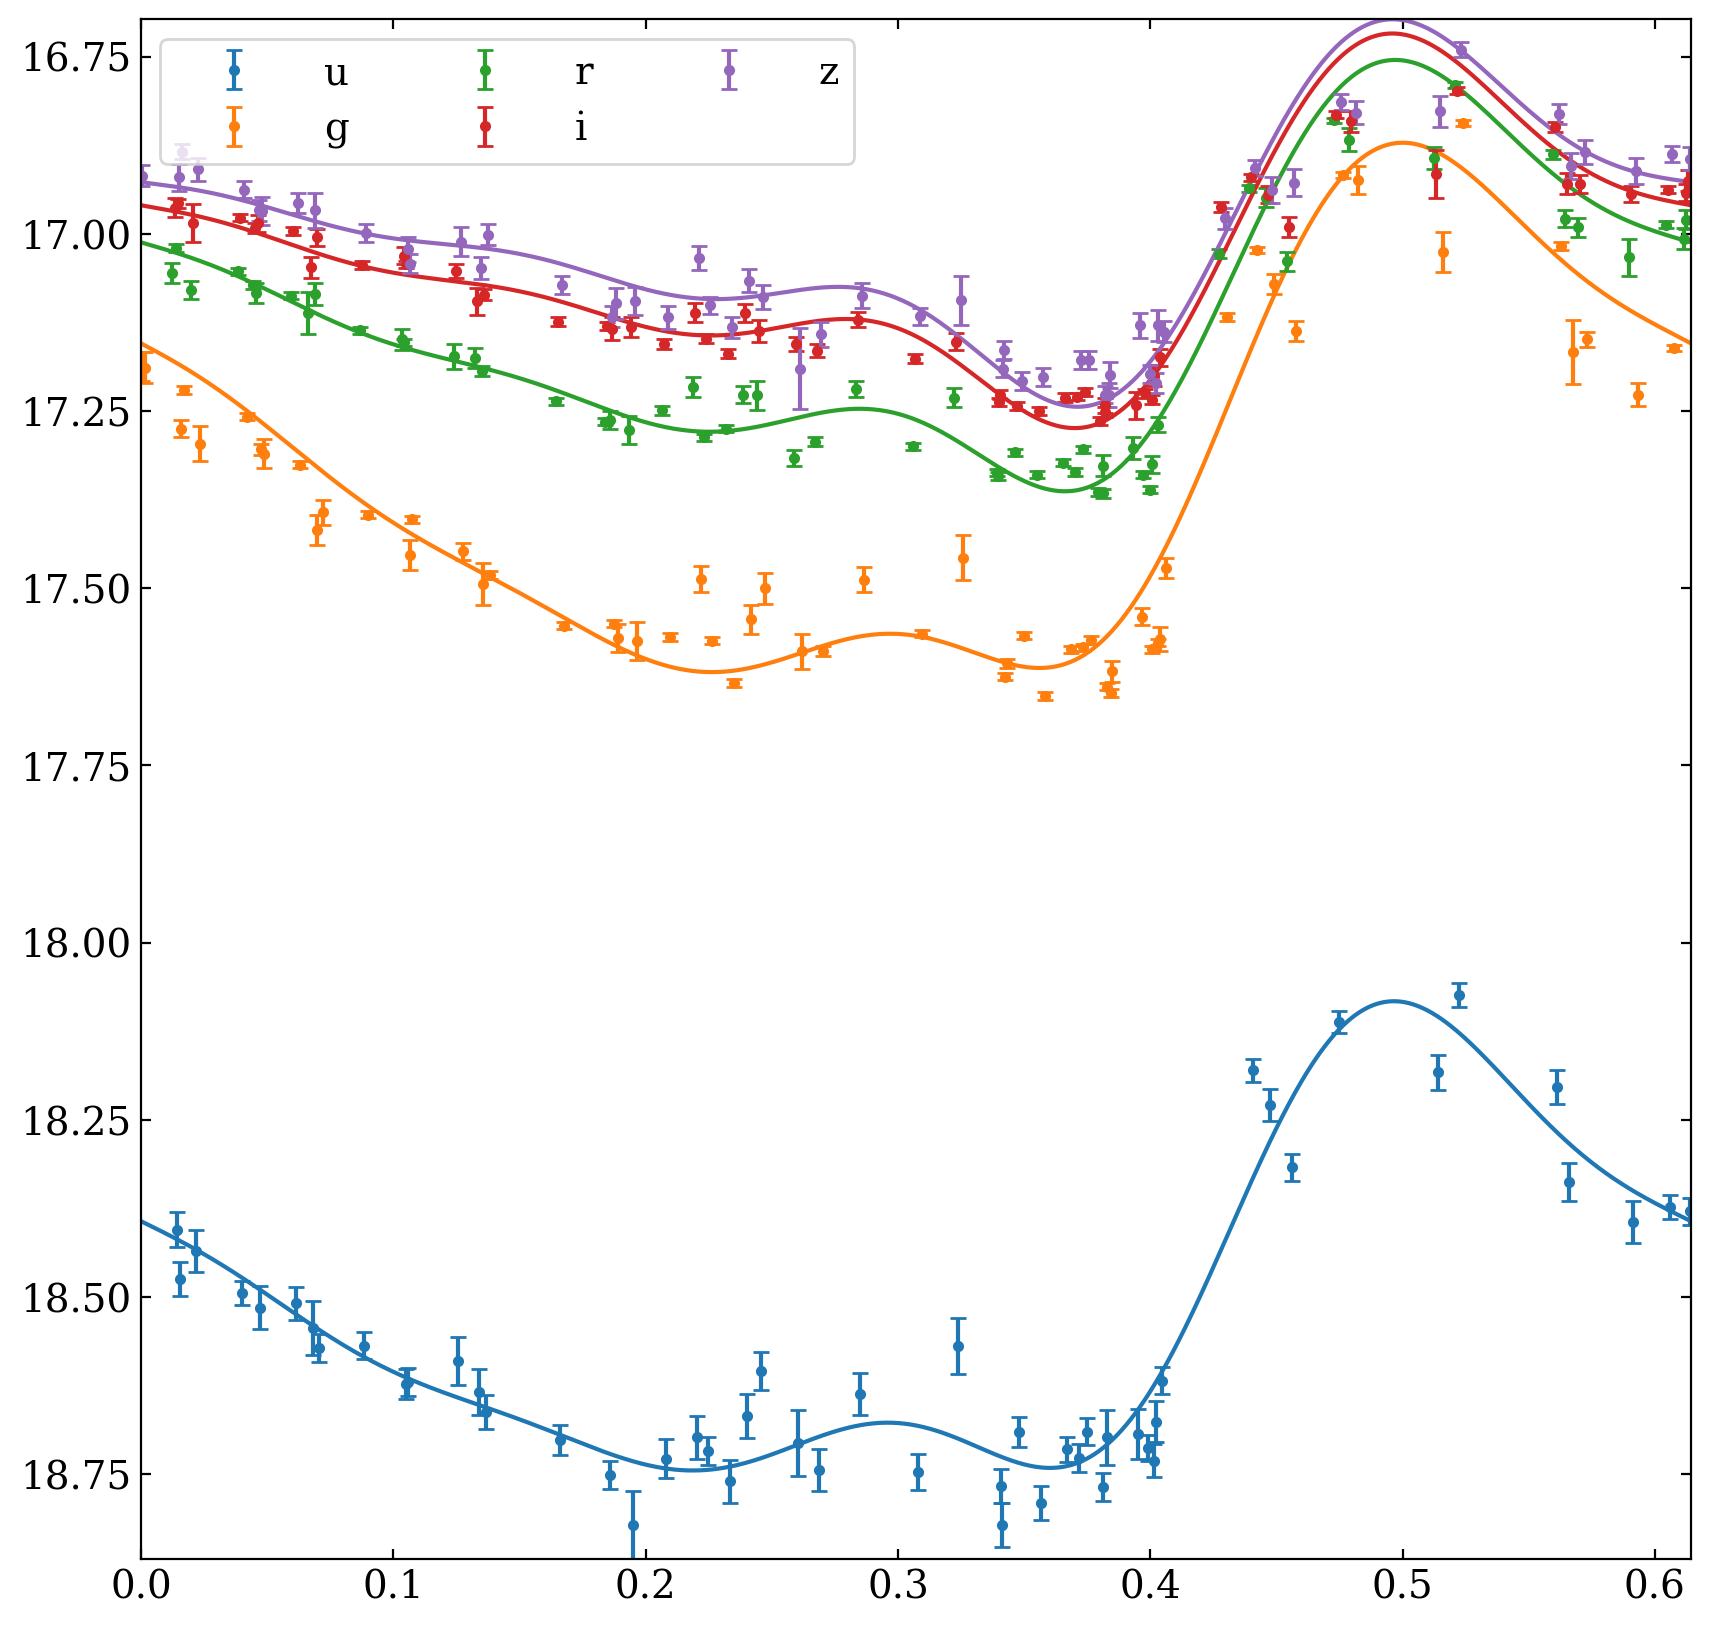

In [31]:
fig = plt.figure(figsize=(10,10))
plot_model(LombScargleMultiband(Nterms_base=4, Nterms_band=1), lcid)

If you have time:

- Explore how `Nterms_base` and `Nterms_band` affect the fit.
- Comment on over/under fitting. 
- Attempt a cross-validation strategy to find the best value of those two parameters.

### Classification

With parameters of a periodic model in hand, and a suite of analyses carried out for all sources, we can attempt to classify our sources. This can either be done using supervised methods (if we have labeled examples) or unsupervised methods (if we do not). The techniques correspond to exactly what you studied in the previous 4 classes, from Classification I through to Deep Learning II.

The examples below show that a sample of variable stars can be divided into different groups. The first plot shows an unsupervised clustering analysis and the second is a supervised GMMB classification.

![Ivezic, Figure 10.20](http://www.astroml.org/_images/fig_LINEAR_clustering_1.png)

![Ivezic, Figure 10.22](http://www.astroml.org/_images/fig_LINEAR_GMMBayes_1.png)